In [ ]:
!pip install --upgrade tensorflow-gpu==2.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0


In [ ]:
# Install required packages
!pip install plotly
!pip install --upgrade nbformat
!pip install nltk
!pip install spacy
!pip install WordCloud
!pip install gensim
!pip install jupyterthemes

# Download NLTK data
import nltk
nltk.download('punkt')

# Import necessary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from jupyterthemes import jtplot

# Set the style of the notebook to be monokai theme
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# load the data
df_true = pd.read_csv("/content/True.csv")
df_fake = pd.read_csv("/content/Fake.csv")

In [ ]:
# add a target class column to indicate whether the news is real or fake
df_true['isfake'] = True
df_true.head()

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True


In [ ]:
df_fake['isfake'] = False
df_fake.head()

,title,text,subject,date,isfake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",False
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",False
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",False
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",False
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",False


In [ ]:
# Concatenate Real and Fake News
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",True
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",False
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",False
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",False
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",False


In [ ]:
df.drop(columns = ['date'], inplace = True)

In [ ]:
# combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,True,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,True,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,True,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,True,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,True,Trump wants Postal Service to charge 'much mor...


In [ ]:
# Explore a sample news
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [ ]:
# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Remove stopwords and remove words with 2 or less characters
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result

In [ ]:
# Apply the function to the dataframe
df['combined'] = df['original'].apply(preprocess)

In [ ]:
print(df['combined'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [ ]:
df

,title,text,subject,isfake,original,combined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,True,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,True,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,True,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,True,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,True,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,False,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,False,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,False,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,False,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal..."


In [ ]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.combined:
    for j in i:
        list_of_words.append(j)


In [ ]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [ ]:
# join the words into a string
df['combined'] = df['combined'].apply(lambda x: " ".join(x))

In [ ]:
df['combined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying need government raise 

In [ ]:
df

,title,text,subject,isfake,original,combined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,True,"As U.S. budget fight looms, Republicans flip t...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,True,U.S. military to accept transgender recruits o...,military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,True,Senior U.S. Republican senator: 'Let Mr. Muell...,senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,True,FBI Russia probe helped by Australian diplomat...,russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,True,Trump wants Postal Service to charge 'much mor...,trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,False,McPain: John McCain Furious That Iran Treated ...,mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,False,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,False,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,False,How to Blow $700 Million: Al Jazeera America F...,blow million jazeera america finally calls qui...


In [ ]:
# text per subject
df_grouped = df[['isfake','subject','text']].groupby(['isfake','subject']).count()
df_grouped

text
isfake subject               
False  Government News   1570
       Middle-east        778
       News              9050
       US_News            783
       left-news         4459
       politics          6841
True   politicsNews     11272
       worldnews        10145

<Axes: xlabel='count', ylabel='subject'>

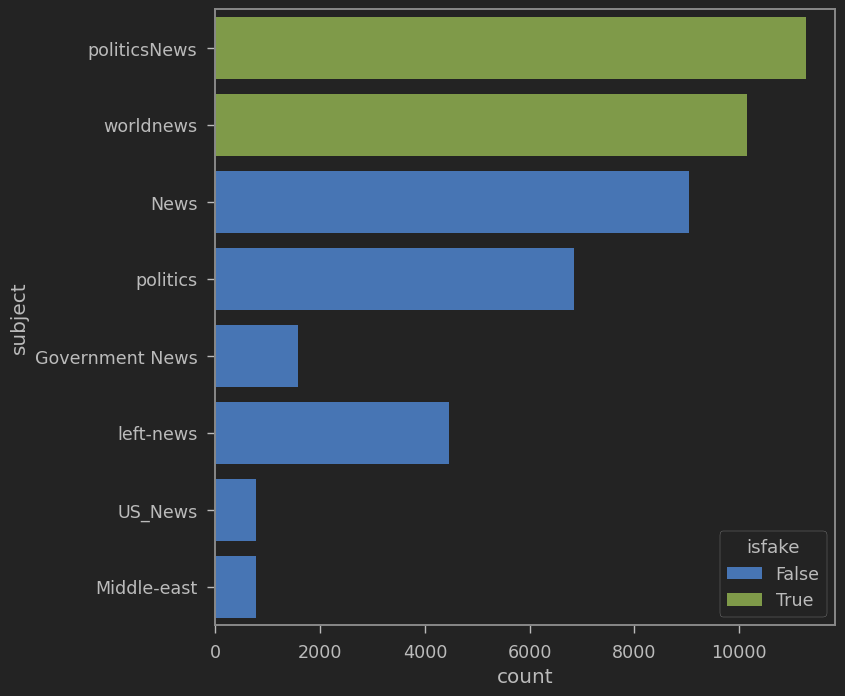

In [ ]:
# plot the counts of words in subjects
plt.figure(figsize = (8,8))
sns.countplot(y = "subject", hue = "isfake", data = df)

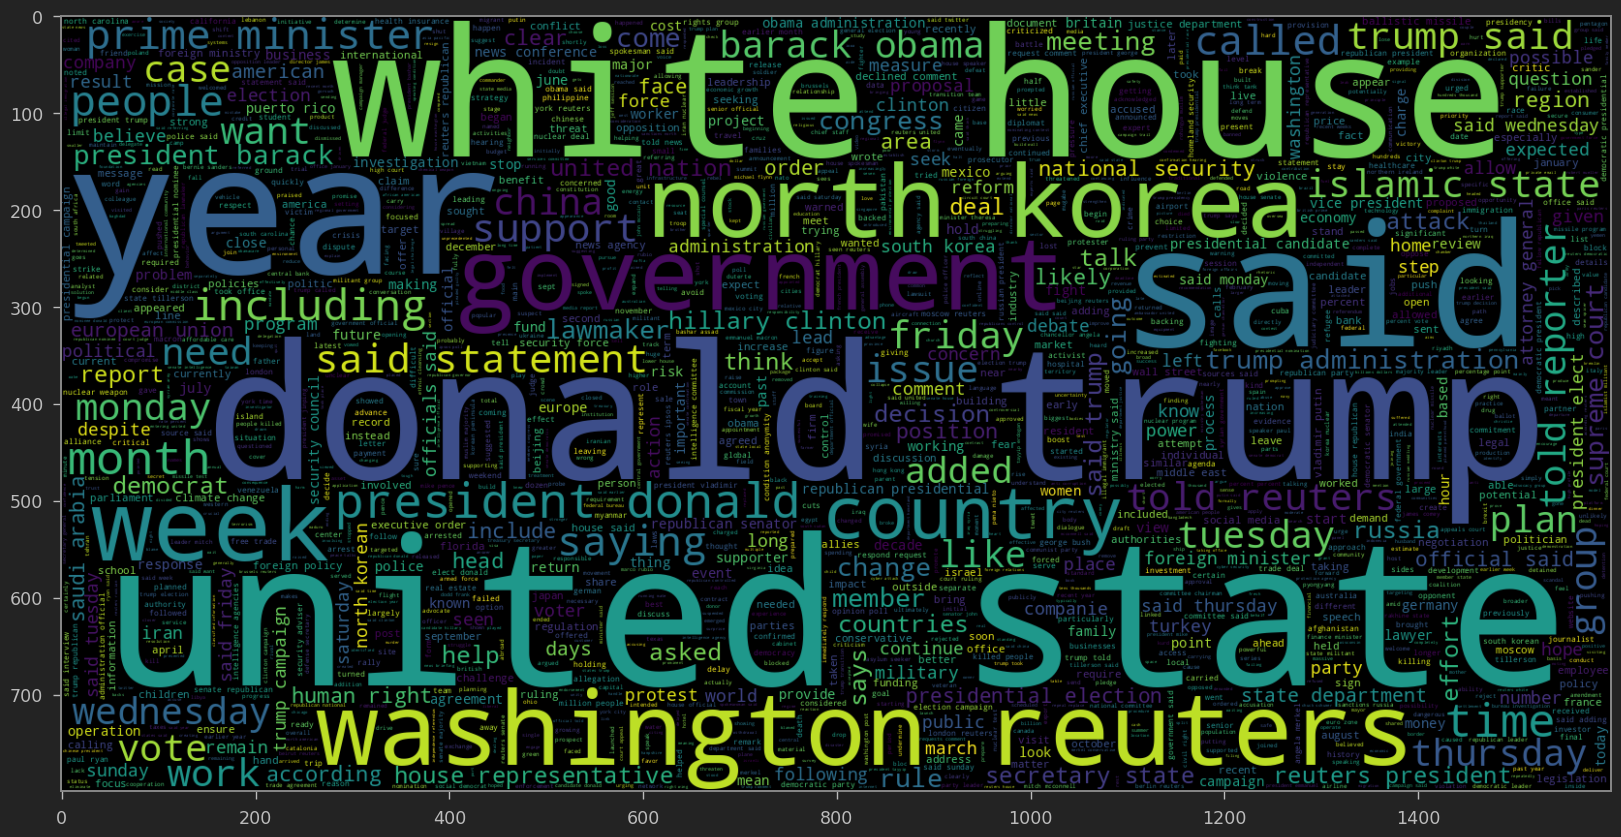

In [ ]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].combined))
plt.imshow(wc, interpolation = 'bilinear')

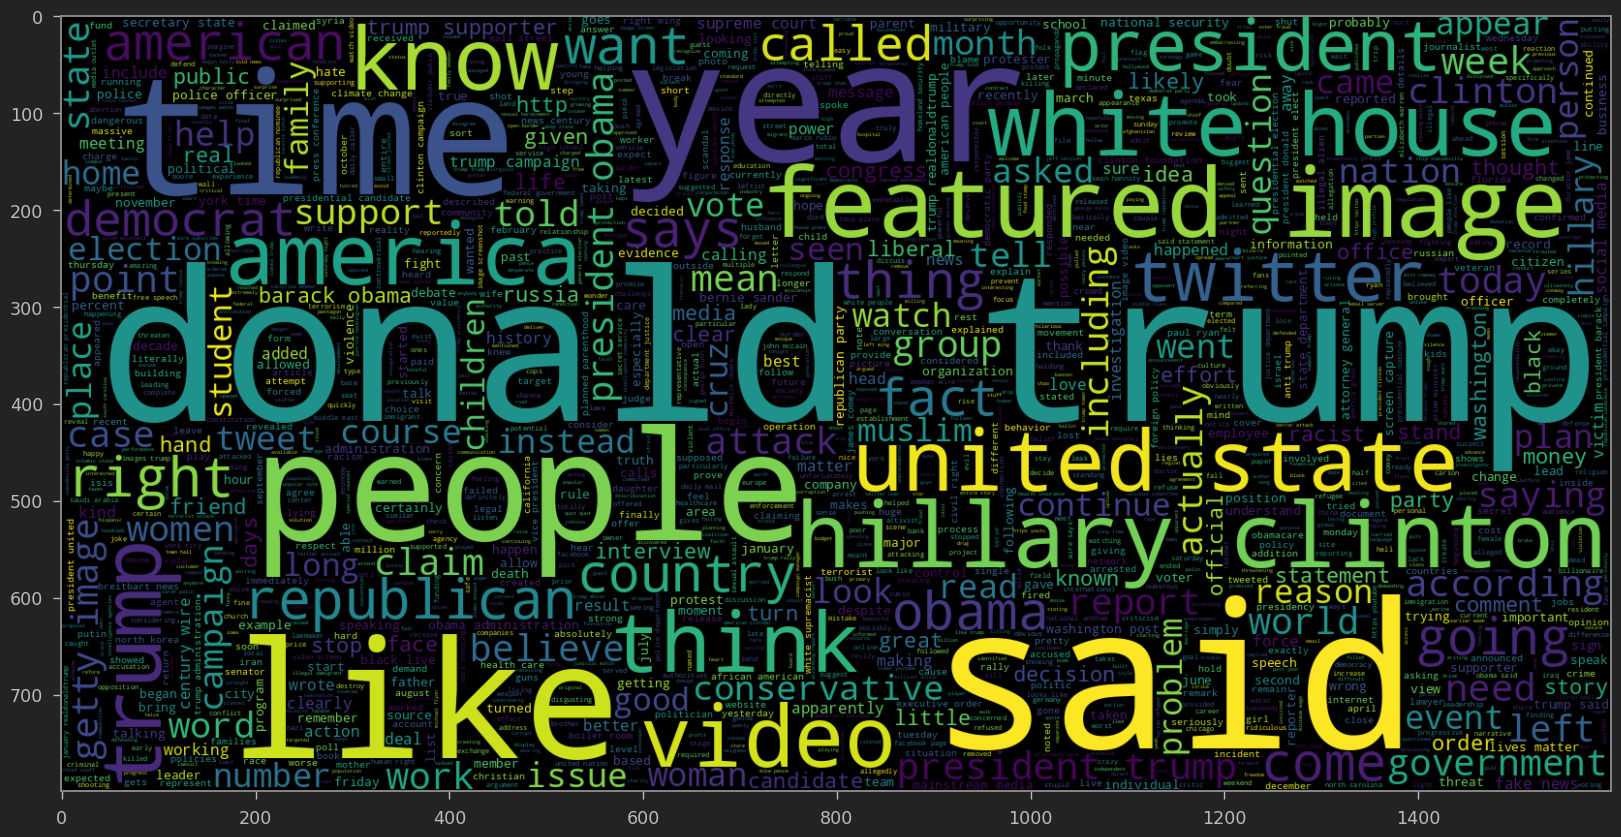

In [ ]:
# plot the word cloud for text that is Fake
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].combined))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
# length of maximum document will be needed to create word embeddings
maxlen = -1
for doc in df.combined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is : ", maxlen)

The maximum number of words in any document is :  4405


In [ ]:
# visualize the distribution of number of words in a text
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.combined], nbins=100)
fig.show()

In [ ]:
# split data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.combined, df.isfake, test_size = 0.2)

In [ ]:
from nltk import word_tokenize

In [ ]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [ ]:
print("The encoding for document\n",df.combined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [ ]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')

In [ ]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [   27     6  6813    43   833   266  4031   208  1243  8812  1844  3877
    43  3701   832   243    90  3397   848 11682  2366 15228   266  5764
  2558  7764    26  2392   354 12856  1233  4302  3878   201  3135  3378
  2734   206   430   430]
The padded encoding for document 2  is :  [  392  2559   169    28   403   621  3257  3934    15     1   166  2008
  1917  1407  3820 49470   825  3528  7119  2142  5846   169    28     3
     1  1138  2163   923 10373  1407   674   320  3782  4761   877 18188
     1 14979  6156  1034]


In [ ]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim=128))

# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirection  (None, 256)               263168    
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14210305 (54.21 MB)
Trainable params: 14210305 (54.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
total_words

108704

In [ ]:
y_train = np.asarray(y_train)

In [ ]:
# train the model
model.fit(padded_train, y_train, batch_size=64,validation_split= 0.1, epochs=4)

Epoch 1/4
506/506 [==============================] - 348s 674ms/step - loss: 0.0398 - acc: 0.9859 - val_loss: 0.0063 - val_acc: 0.9981
Epoch 2/4
506/506 [==============================] - 353s 697ms/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0077 - val_acc: 0.9986
Epoch 3/4
506/506 [==============================] - 351s 694ms/step - loss: 4.0648e-04 - acc: 0.9999 - val_loss: 0.0097 - val_acc: 0.9986
Epoch 4/4
506/506 [==============================] - 347s 686ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 0.0133 - val_acc: 0.9989


In [ ]:
# make prediction
pred = model.predict(padded_test)

281/281 [==============================] - 14s 46ms/step


In [ ]:
# if the predicted value is >0.5 it is real else it is fake
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [ ]:
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test),prediction)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9956570155902005


<Axes: >

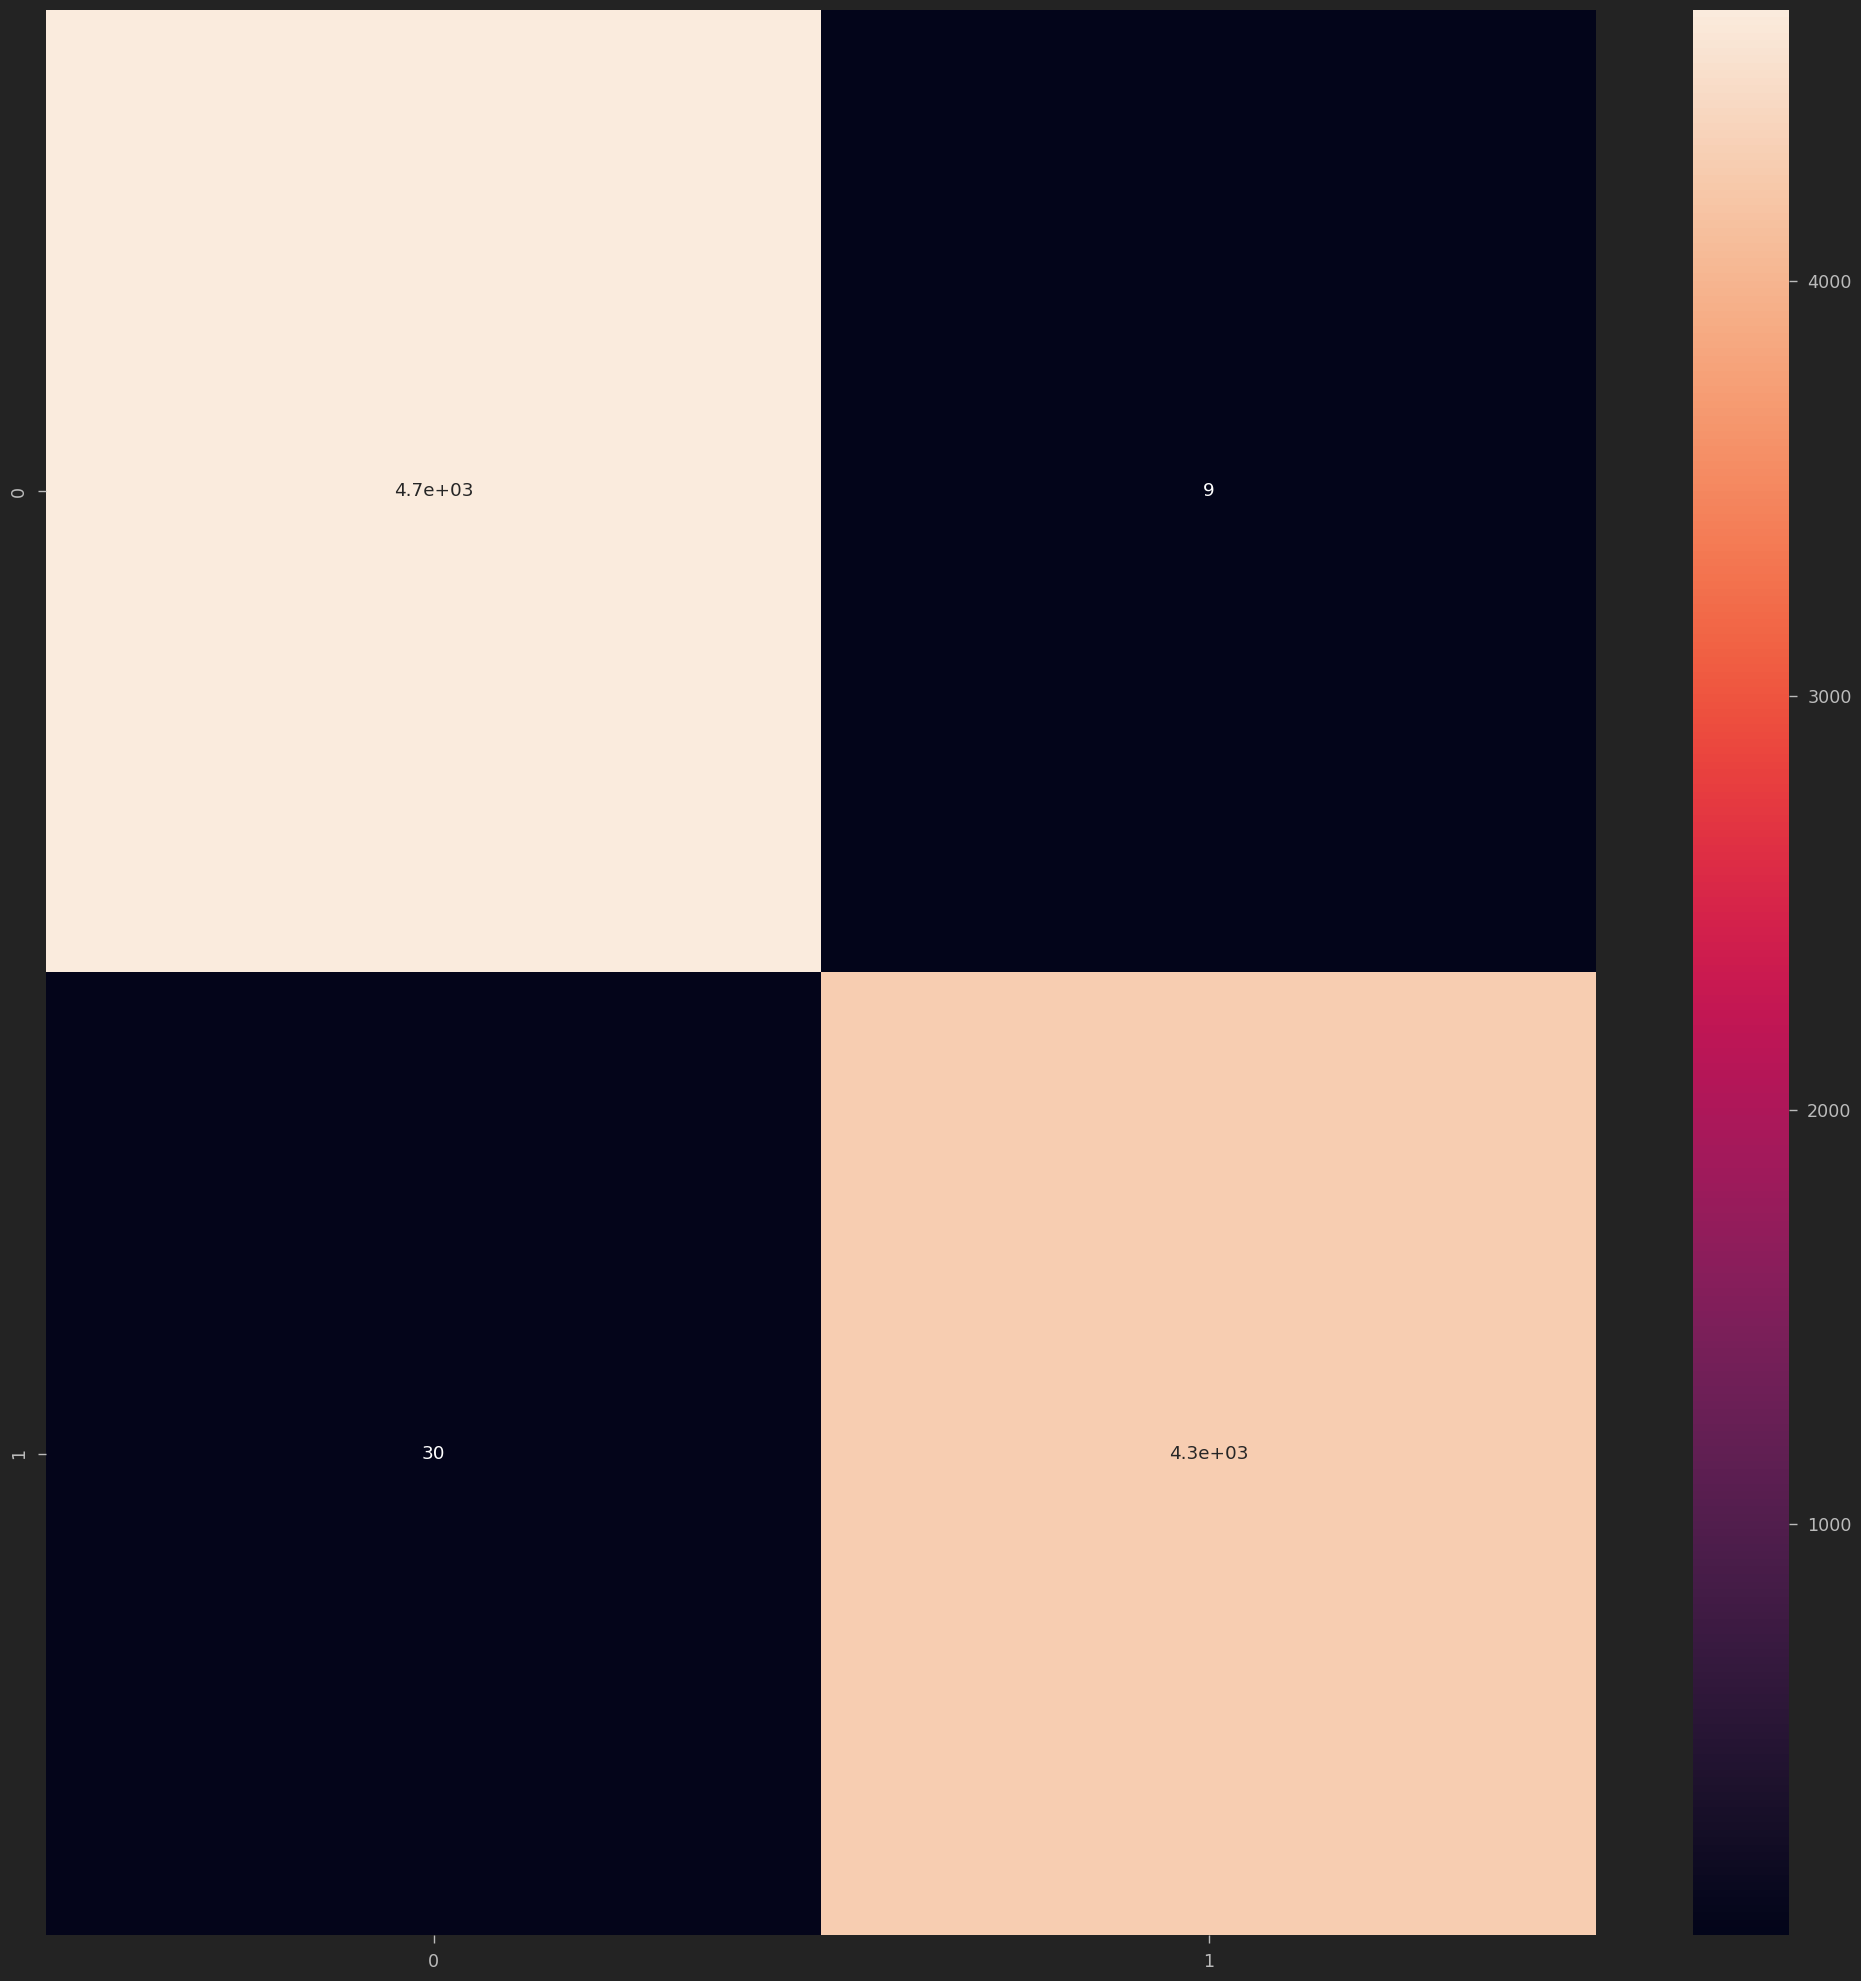

In [ ]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [ ]:
# category dict
category = { 0: 'Fake News', 1 : "Real News"}

In [ ]:
for i in range(len(prediction[:5])):
    temp_df = df[df.combined == x_test.values[i]]
    if not temp_df.empty:
        print("Title :\n\n" ,temp_df.title.values[0],"\n\nTopic :\n\n", temp_df.subject.values[0],
              "\n\nNews :\n\n", temp_df.text.values[0], "\n\nOriginal value :\n\n",
              category[temp_df.isfake.values[0]], "\n\nPredicted value :\n\n", category[prediction[i]], "\n\n\n")
    else:
        print("No matching row found in DataFrame for index:", i, "\n\n\n")


Title :

 Legal battle over travel ban pits Trump's powers against his own words 

Topic :

 politicsNews 

News :

  NEW YORK (Reuters) - A U.S. appeals court is weighing arguments for and against President Donald Trump’s temporary travel ban, but its decision this week may not yet answer the underlying legal questions being raised in the fast-moving case.  The 9th U.S. Circuit Court of Appeals in San Francisco is expected to rule only on the narrow question of whether a lower court’s emergency halt to an executive order by Trump was justified. Trump signed the order on Jan. 27 barring citizens from seven Muslim-majority countries for 90 days and halted all refugee entries for four months.  The appeals court has several options. It could kick the case back to lower court judge James Robart in Seattle, saying it is premature for them to make a ruling before he has had a chance to consider all the evidence. Robart stopped Trump’s order just a week after he issued it and before all the a

In [ ]:
# data containing real news
df_true
# data containing fake news
df_fake
# dataframe information
df_true.info()
# dataframe information
df_fake.info()
# check for null values
df_true.isnull().sum()
# check for null values
df_fake.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   isfake   21417 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 690.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   isfake   23481 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 756.8+ KB


title      0
text       0
subject    0
date       0
isfake     0
dtype: int64